# Kormann–Meixner Footprint Tutorial
Using the **kormannmeixner** implementation and a sample half‑hourly micrometeorological record from the AmeriFlux US‑UTE tower (attached CSV), this notebook shows how to
1. load the data,
2. derive the parameters required by the analytical footprint model, and
3. visualise both the cross‑wind‑integrated and full 2‑D flux footprints.

Feel free to adapt the code for your own sites and data sets!

## 1. Imports & Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import sys
sys.path.insert(0, os.path.abspath("../../src"))  # adjust path as needed
from fluxfootprints import kormannmeixner

%matplotlib inline
plt.rcParams['figure.dpi']=120

## 2. Load the half‑hourly tower data

In [5]:
data_path = Path('US-UTE_HH_202406241430_202409251400.csv')
df = pd.read_csv(data_path, parse_dates=['TIMESTAMP_START'])
df = df.set_index('TIMESTAMP_START')
df.head()

,datetime_start,TIMESTAMP_END,CO2,CO2_SIGMA,H2O,H2O_SIGMA,FC,FC_SSITC_TEST,LE,LE_SSITC_TEST,...,TA_1_2_1,RH_1_2_1,T_DP_1_2_1,TA_1_3_1,RH_1_3_1,T_DP_1_3_1,TA_1_4_1,PBLH_F,TS_2_1_1,SWC_2_1_1
TIMESTAMP_START,,,,,,,,,,,,,,,,,,,,,
2024-06-24 14:30:00,2024-06-24 14:30:00,202406241500,427.0199,0.628133,17.26862,1.019290,0.069210,-9999.0,156.40850,-9999.0,...,29.95141,33.26877,12.052600,30.32464,33.45364,12.46181,30.06976,1665.4670,25.72815,22.44161
2024-06-24 15:00:00,2024-06-24 15:00:00,202406241530,425.9499,1.019297,15.18936,0.703052,0.285446,-9999.0,138.30920,-9999.0,...,30.02516,29.22197,10.155240,30.35956,29.77183,10.72635,30.13765,1765.9350,25.52736,22.41975
2024-06-24 15:30:00,2024-06-24 15:30:00,202406241600,426.4163,1.965228,14.87533,0.808026,1.081928,-9999.0,154.11530,-9999.0,...,30.24634,28.28498,9.838229,30.69433,28.63222,10.41335,30.40344,1495.7350,25.12511,22.32785
2024-06-24 16:00:00,2024-06-24 16:00:00,202406241630,426.0534,2.665907,15.61140,1.002919,0.519664,-9999.0,135.56180,-9999.0,...,30.75179,28.75255,10.538220,31.14621,29.16225,11.09066,30.90061,1491.0620,24.63557,22.18172
2024-06-24 16:30:00,2024-06-24 16:30:00,202406241700,427.8476,1.102921,15.21034,0.703084,1.147608,-9999.0,95.06287,-9999.0,...,29.16274,30.77158,10.165810,29.57434,30.96792,10.63069,29.30510,341.9711,24.14865,22.03216


## 3. Choose a period
For demonstration we pick one half‑hour with few missing values and reasonably high turbulence.

In [6]:
# heuristic filter
good = df[(df['USTAR']>0.15) & (df['WS']>1) & df['MO_LENGTH'].notna()]
row = good.iloc[0]
row.name

Timestamp('2024-06-24 14:30:00')

### Extract the required micrometeorological parameters

In [7]:
# --- REQUIRED INPUTS ---
z_m = 20.0      # measurement height above displacement height [m] (edit!)
z_0 = 0.03      # aerodynamic roughness length [m] (edit!)

L       = row['MO_LENGTH']    # Obukhov length [m]
u_star  = row['USTAR']        # friction velocity [m s‑1]
u_zm    = row['WS']           # mean wind speed at z_m [m s‑1]
sigma_v = row['V_SIGMA']      # cross‑wind velocity std‑dev [m s‑1]

pd.DataFrame({
    'parameter':['z_m','z_0','L','u_star','u_zm','sigma_v'],
    'value':[z_m,z_0,L,u_star,u_zm,sigma_v]
})

,parameter,value
0,z_m,20.000000
1,z_0,0.030000
2,L,-21.726630
3,u_star,0.285427
4,u_zm,4.118659
5,sigma_v,1.243537


## 4. Run the Kormann–Meixner model

In [8]:
# Step 1: power‑law exponents for wind speed (m) and eddy diffusivity (n)
m, n, U, kappa = kormannmeixner.analytical_power_law_parameters(z_m, z_0, L, u_star, u_zm)
xi = kormannmeixner.length_scale_xi(z_m, U, kappa, m, n)
print(f'm={m:.3f}, n={n:.3f}, ξ={xi:.2f} m')

m=0.087, n=1.468, ξ=475.12 m


### Cross‑wind‑integrated footprint $f(x)$

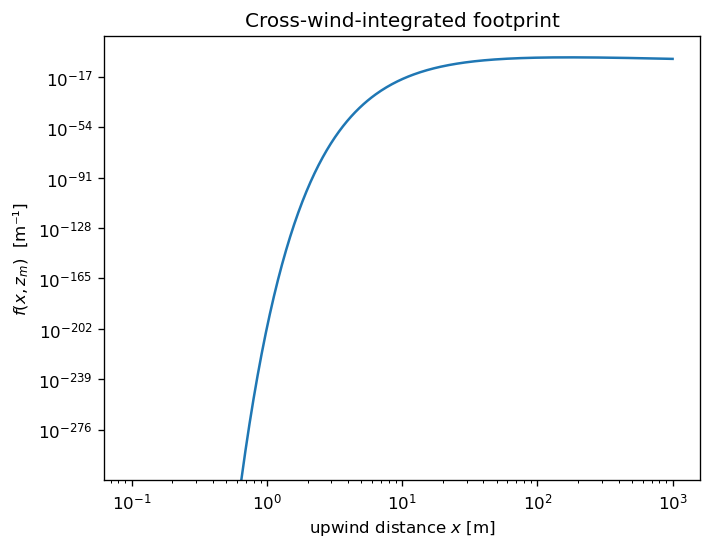

In [9]:
x = np.logspace(-1, 3, 400)  # 0.1 … 1000 m
f_x = kormannmeixner.crosswind_integrated_footprint(x, xi, m, n)
plt.figure()
plt.loglog(x, f_x)
plt.xlabel('upwind distance $x$ [m]')
plt.ylabel('$f(x, z_m)$  [m⁻¹]')
plt.title('Cross‑wind‑integrated footprint')
plt.show()

### 2‑D footprint $\varphi(x,y)$

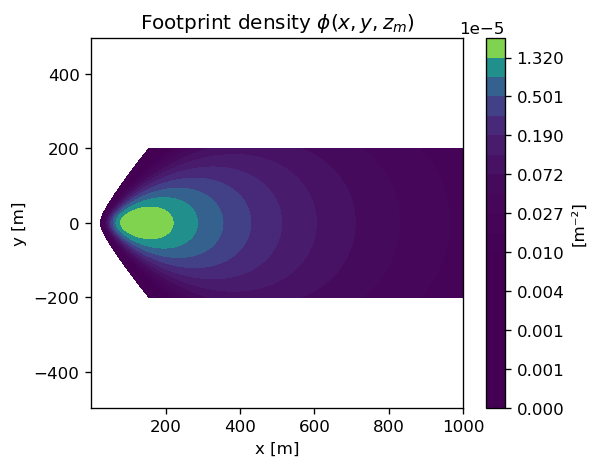

In [10]:
X, Y, phi = kormannmeixner.footprint_2d(
    x,                           # along‑wind distances
    np.linspace(-200, 200, 401), # cross‑wind distances
    xi, m, n, u_zm, sigma_v)

plt.figure(figsize=(5,4))
levels = np.geomspace(phi.max()*1e-4, phi.max(), 20)
cs = plt.contourf(X, Y, phi, levels=levels)
plt.xlabel('x [m]'); plt.ylabel('y [m]')
plt.title('Footprint density $\phi(x,y,z_m)$')
plt.colorbar(cs, label='[m⁻²]')
plt.axis('equal');
plt.show()

### Effective fetch
The along‑wind distance containing a specified cumulative fraction of the flux (here 80 %).

In [11]:
fraction = 0.8
fetch80 = kormannmeixner.effective_fetch(fraction, xi, m, n)
print(f'Effective fetch for {fraction*100:.0f}% cumulative flux: {fetch80:.1f} m')

Effective fetch for 80% cumulative flux: 715.7 m


## 5. Vectorising for many timesteps (optional)
This section illustrates how to wrap the above steps into a function and apply it across the time‑series to analyse footprint statistics. For brevity it is left as an exercise; see the supplied `compute_footprint_timeseries` function stub in the next cell.

In [12]:
def compute_footprint_timeseries(df, z_m, z_0):
    """Return a Series of effective fetch distances for each row in *df* (half‑hour)."""
    out = []
    for ts, row in df.iterrows():
        if pd.isna(row['MO_LENGTH']):
            out.append(np.nan); continue
        m, n, U, k = kormannmeixner.analytical_power_law_parameters(
            z_m, z_0, row['MO_LENGTH'], row['USTAR'], row['WS'])
        xi = kormannmeixner.length_scale_xi(z_m, U, k, m, n)
        fetch = kormannmeixner.effective_fetch(0.8, xi, m, n)
        out.append(fetch)
    return pd.Series(out, index=df.index, name='fetch80')

> **Next steps:** compute the time‑series, plot a histogram, or relate fetch to environmental drivers.